In [1]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import osmnx as ox
import contextily as cx
import numpy as np
import joblib
from pyrosm import OSM, get_data

c:\Users\diogo\Desktop\MS\MS-FEUP\.venv\Lib\site-packages\pyrosm\networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


<Axes: >

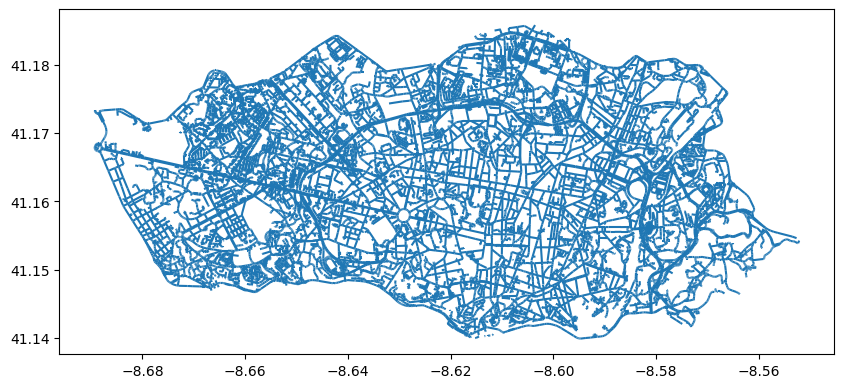

In [2]:
osm_fp = "./openstreetmap data/porto.osm.pbf"
# We will use test data for Helsinki that comes with pyrosm
osm = OSM(osm_fp)

# Parse roads that can be driven by car
roads = osm.get_network(network_type="driving")
roads.plot(figsize=(10,10))

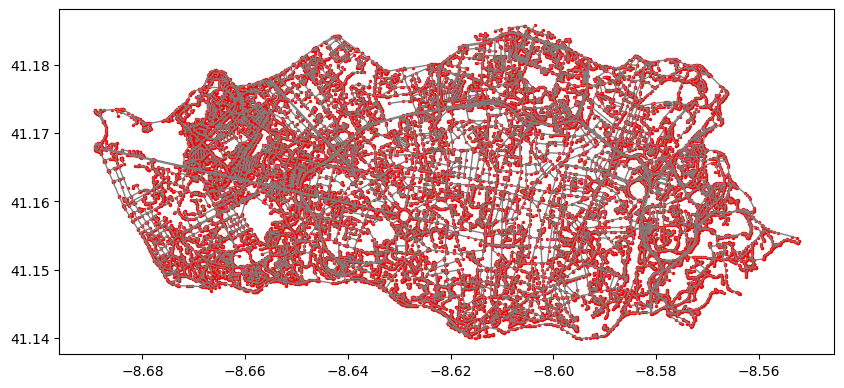

In [3]:
# Parse nodes and edges
road_nodes, road_edges = osm.get_network(network_type="driving", nodes=True)

# Plot the data
ax = road_edges.plot(figsize=(10,10), color="gray", lw=1.0)
ax = road_nodes.plot(ax=ax, color="red", markersize=2)

In [4]:
data_folder = "./openstreetmap data/"
stcp_nodes = gpd.read_file(data_folder + "stcp_nodes.gpkg")
stcp_edges = gpd.read_file(data_folder + "stcp_edges.gpkg")
metro_nodes = gpd.read_file(data_folder + "metro_nodes.gpkg")
metro_edges = gpd.read_file(data_folder + "metro_edges.gpkg")

stcp_nodes.crs = "EPSG:4326"
stcp_edges.crs = "EPSG:4326"

G = osm.to_graph(stcp_nodes, stcp_edges, graph_type="networkx")

In [5]:
ox.plot_graph_folium(G)


C:\Users\diogo\AppData\Local\Temp\ipykernel_6020\2823849218.py:1: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_graph_folium(G)


In [6]:
# Origin
orig_address = "Av. da Boavista 604-610, 4149-071 Porto"
orig_y, orig_x = ox.geocode(orig_address)  # notice the coordinate order (y, x)!

# Destination
dest_address = "Rua D. Frei Vicente da Soledade e Castro, Porto"
dest_y, dest_x = ox.geocode(dest_address) 

print("Origin coords:", orig_x, orig_y)
print("Destination coords:", dest_x, dest_y)

Origin coords: -8.63065 41.1585419
Destination coords: -8.5982521 41.17761


In [7]:
# 1. Find the closest nodes for origin and destination
orig_node_id, dist_to_orig = ox.distance.nearest_nodes(G, X=orig_x, Y=orig_y, return_dist=True)
dest_node_id, dist_to_dest = ox.distance.nearest_nodes(G, X=dest_x, Y=dest_y, return_dist=True)

print("Origin node-id:", orig_node_id, "and distance:", dist_to_orig, "meters.")
print("Destination node-id:", dest_node_id, "and distance:", dist_to_dest, "meters.")

Origin node-id: BCM4 and distance: 59.825321219958646 meters.
Destination node-id: FEUP2 and distance: 169.04204911132285 meters.


In [8]:
# Calculate the paths
metric_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='length')
time_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

# Get also the actual travel times (summarize)
travel_length = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='length')
travel_time = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

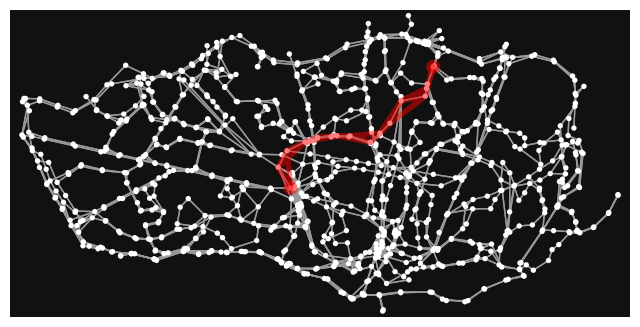

Text(0.5, 213.07593970246575, 'Shortest path distance  4383.0 meters.')

In [9]:
fig, ax = ox.plot_graph_route(G, metric_path)  # ou time_path

# Add the travel time as title
ax.set_xlabel("Shortest path distance {t: .1f} meters.".format(t=travel_length))

In [10]:
ox.plot_route_folium(G, metric_path)  # visualização diferente da mesma coisa


C:\Users\diogo\AppData\Local\Temp\ipykernel_6020\1075752465.py:1: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, metric_path)  # visualização diferente da mesma coisa


In [11]:
sections = gpd.read_file(data_folder + "sections.gpkg")
# sections.crs = "EPSG:4326"

# sections.geometry = sections.geometry.centroid
# rename column DTMNFRSEC21 to id
sections.rename(columns={'DTMNFRSEC21': 'id'}, inplace=True)

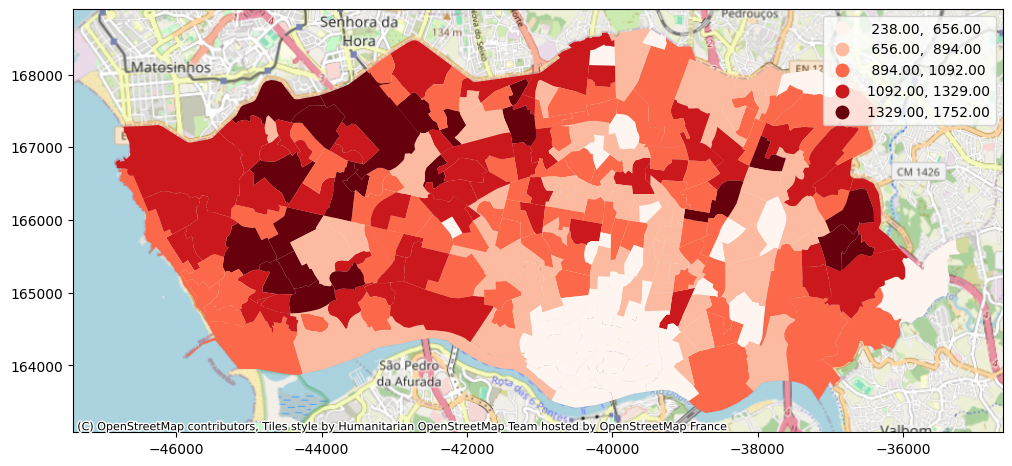

In [12]:
ax = sections.plot("N_INDIVIDUOS", scheme="natural_breaks", cmap="Reds", figsize=(12,12), legend=True, markersize=3.5)
cx.add_basemap(ax, crs=sections.crs)

In [13]:
# matrix = pd.DataFrame({'from_id': sections['id'].values.repeat(len(sections)), 'to_id': np.tile(sections['id'].values, len(sections))})
# ...

matrix = joblib.load(data_folder + 'matrix.pkl')

In [14]:
matrix

,from_id,to_id,metric_path,metric_path2
0,131217050,131217050,None,None
1,131217050,131217049,"[PISC, BSB, BCG]","[PISC, BSB, BCG]"
2,131217050,131203025,"[PISC, AQL1, FG1, MPL7, TXP1, SCR1, MAV2, IANT...","[PISC, AQL1, FG1, MPL7, TXP1, SCR1, MAV2, IANT..."
3,131217050,131203017,"[PISC, AQL1, FG1, MPL7, TXP1, SCR1, MAV2, IANT...","[PISC, AQL1, FG1, MPL7, TXP1, SCR1, MAV2, IANT..."
4,131217050,131217028,"[PISC, BSB, BCG, SP]","[PISC, BSB, BCG, SP]"
...,...,...,...,...
59044,131202012,131202001,"[BFM4, C24A5, DJOA4, BLM, MCBL3, PRDJ, AL3, MS...","[BFM4, C24A5, DJOA4, BLM, MCBL3, PRDJ, AL3, MS..."
59045,131202012,131217017,"[BFM4, C24A5, DJOA4, BLM, BLFZ1, JN3, TRD5]","[BFM4, C24A5, DJOA4, BLM, BLFZ1, JN3, TRD5]"
59046,131202012,131211033,"[BFM4, C24A5, DJOA4, BLM, BLFZ1, JN3, PRR1, FI...","[BFM4, C24A5, DJOA4, BLM, BLFZ1, JN3, PRR1, FI..."
59047,131202012,131202014,"[BFM4, C24A5, DJOA4, RFZ1, MOR2, ESCN2]","[BFM4, C24A5, DJOA4, RFZ1, MOR2, ESCN2]"


metric_path é de ter corrido o djikstra entre todos os nós e guardado o caminho mais curto entre cada par de nós (demorou 6 horas e o topo da rede estava cortada/interrompida)

metric_path2 é de ter corrido o floyd_warshall e guardado o caminho mais curto entre cada par de nós
(demorou menos de 10 minutos)

In [15]:
sections_nearest = sections.copy()
sections_nearest['nearest_node'] = sections.apply(lambda x: ox.distance.nearest_nodes(G, x.geometry.centroid.x, x.geometry.centroid.y), axis=1)

In [16]:
# demora uns 5 min a correr

floyd_predecessors, floyd_distances = nx.floyd_warshall_predecessor_and_distance(G, weight='length')

Create Walking Edges on Current Network

In [29]:
# Create a copy of the original graph to preserve it
G_with_walking = G.copy()

# Count original edges
original_edges = G.number_of_edges()

# Maximum walking distance in meters
MAX_WALKING_DISTANCE = 300
WALKING_SPEED = 1.2  # meters per second (about 5 km/h)

# Get node positions
node_positions = {node: (data['y'], data['x'])  # (lat, lon)
                 for node, data in G.nodes(data=True)}

# Add a progress counter
total_nodes = len(G.nodes())
processed_nodes = 0
walking_edges_added = 0

for node1 in G.nodes():
    pos1 = node_positions[node1]  # (lat, lon)
    
    for node2 in G.nodes():
        if node1 != node2:
            pos2 = node_positions[node2]  # (lat, lon)
            
            # Calculate actual distance in meters
            distance = haversine_distance(pos1[0], pos1[1], pos2[0], pos2[1])
            
            if distance <= MAX_WALKING_DISTANCE and not G_with_walking.has_edge(node1, node2):
                G_with_walking.add_edge(node1, node2,
                                      length=distance,
                                      travel_time_seconds=distance/WALKING_SPEED,
                                      mode='walking')
                walking_edges_added += 1

final_edges = G_with_walking.number_of_edges()

print(f"Walking edges added: {walking_edges_added}")
print(f"Total edges in new network: {final_edges}")
print(f"Percentage increase: {((final_edges/original_edges) - 1)*100:.1f}%")

# Visualization
ox.plot_graph(G_with_walking, 
              edge_color=['blue' if d.get('mode')=='walking' else 'gray' for u,v,d in G_with_walking.edges(data=True)],
              edge_linewidth=0.5)

Join Bus with Metro

In [17]:
# for all 